In [176]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


factors_list = ['因子_開盤前5分鐘', 
                "因子_開盤前15分鐘", 
                "因子_開盤前所有時間"]
returns_list = ["回報_開盤後5分鐘", 
                "回報_開盤後15分鐘", 
                "回報_開盤後到收盤",
                '回報_開盤5分鐘後到收盤', 
                '回報_開盤15分鐘後到收盤']

def get_df_from_mt5_csv(fnames):
    if isinstance(fnames, str):
        df = pd.read_csv(fnames, sep="\t")
        df.columns = ['da', 'time', "op", 'hi', "lo", "cl", "a", "b", "c"]
        return df.iloc[:, :6]
    
    elif isinstance(fnames, (list, tuple)):
        dfs = []
        for fname in fnames:
            df = pd.read_csv(fname, sep="\t")
            df.columns = ['da', 'time', "op", 'hi', "lo", "cl", "a", "b", "c"]
            dfs.append(df.iloc[:, :6])
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df['da'] = pd.to_datetime(combined_df['da'])  # Convert 'da' to datetime
        combined_df.sort_values(by=['da', 'time'], inplace=True)
        combined_df = combined_df.drop_duplicates(subset=['da', 'time'])
        return combined_df

    else:
        raise ValueError("fnames should be a string (single file) or a list/tuple of file paths")

def calc_ratio(x, type_=""):
    try:
        if type_ == ["因子_開盤前5分鐘", "回報_開盤後5分鐘"]:
            return x.iloc[0, 1] / x.iloc[0, 0] - 1  
        elif type_ in [
            "因子_開盤前15分鐘", 
            "因子_開盤前所有時間",
            "回報_開盤後15分鐘",
            '回報_開盤後到收盤',
            "回報_開盤5分鐘後到收盤",
            "回報_開盤15分鐘後到收盤"]:
            return x.iloc[1, 1] / x.iloc[0, 0] - 1  
        else:
            return x.iloc[1, 1] / x.iloc[0, 0] - 1  
    except IndexError:
        return None  

def get_factor(df, d_early, d_late, factor_name):
    return (
    df[df['time'].isin([d_early, d_late])]
    .groupby("da", group_keys=False)[["op", "cl"]]  
    .apply(lambda x: calc_ratio(x, factor_name), include_groups=False)
    )
    
def get_simulated_return(df, d_early, d_late, return_name):
    return (
    df[df['time'].isin([d_early, d_late])]
    .groupby("da", group_keys=False)[["op", "cl"]]  
    .apply(lambda x: calc_ratio(x, return_name), include_groups=False)
    )
def df_factor_profit_bt(df, factors_list:list, returns_list:list, plots=True):
    ic_ratio_list = {}
    if len(factors_list) == 0: return; 
    if len(returns_list) == 0: return;
    
    for factor in factors_list:
        df['signal_dto'] = df[factor].apply(lambda x: 1 if x < 0 else -1)
        
        for ret in returns_list:
            df_temp = df[['signal_dto', ret]].dropna(how='any')
            ic_ratio = np.corrcoef(df_temp['signal_dto'], df_temp[ret])[0, 1]
            ic_ratio_list[f"{factor} for {ret}"] = ic_ratio
    ic_ratio_list = dict(sorted(ic_ratio_list.items(), key=lambda item: item[1], reverse=True))
    if plots:
        pass;
    return ic_ratio_list, df

def calculate_strategy_statistics(df, ret_column, risk_free_rate=0.02, plot=True):
    df = df.copy()
    
    # Calculate Cumulative Returns
    df['cumulative_returns'] = df[ret_column].cumsum()

    # Maximum Drawdown (MDD)
    df['cumulative_max'] = df['cumulative_returns'].cummax()  # Track the running maximum
    df['drawdown'] = df['cumulative_returns'] - df['cumulative_max']  # Difference from the peak
    df['drawdown_pct'] = df['drawdown'] / df['cumulative_max']  # Drawdown as percentage of peak
    max_drawdown = df['drawdown_pct'].min()  # Most negative value represents maximum drawdown

    # Sharpe Ratio (Annualized)
    daily_return_std = df[ret_column].std()
    sharpe_ratio = (df[ret_column].mean() - risk_free_rate / 252) / daily_return_std * np.sqrt(252)

    # Sortino Ratio (Uses downside volatility)
    downside_returns = df[ret_column][df[ret_column] < 0]
    downside_std = downside_returns.std()
    sortino_ratio = (df[ret_column].mean() - risk_free_rate / 252) / downside_std * np.sqrt(252)

    # Calmar Ratio (Annualized Return / MDD)
    annual_return = df[ret_column].mean() * 252
    calmar_ratio = abs(annual_return / max_drawdown)

    # Win Rate & Profit Factor
    win_trades = df[ret_column][df[ret_column] > 0]
    loss_trades = df[ret_column][df[ret_column] < 0]
    win_rate = len(win_trades) / len(df[ret_column])
    profit_factor = win_trades.sum() / abs(loss_trades.sum())

    # Results Dictionary
    stats = {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Max Drawdown (%)": max_drawdown,
        "Annualized Return (%)": annual_return * 100,
        "Win Rate (%)": win_rate * 100,
        "Profit Factor": profit_factor
    }

    if plot:
        # Create subplots with 2 y-axes and 2 rows
        fig = make_subplots(
            rows=2, cols=1,  # Create two rows
            shared_xaxes=True,
            vertical_spacing=0.1,  # Add spacing between subplots
            subplot_titles=("策略 vs. 大盤", "回檔"),
            specs=[[{"secondary_y": True}], [{}]]  # Primary and secondary y-axes for first plot, second plot is just one axis
        )

        # Cumulative Profit Line (Primary y-axis)
        fig.add_trace(go.Scatter(
            x=df.index, y=df['cumulative_returns'],
            mode="lines", name="策略", line=dict(color="blue")
        ), row=1, col=1, secondary_y=False)  # Assign to primary y-axis (1st row)

        # OP Line (Secondary y-axis)
        fig.add_trace(go.Scatter(
            x=df.index, y=df['op'],
            mode="lines", name="大盤", line=dict(color="orange")
        ), row=1, col=1, secondary_y=True)  # Assign to secondary y-axis (1st row)

        # Calculate Maximum Drawdown (MDD)
        df['drawdown'] = df['cumulative_returns'] - df['cumulative_returns'].cummax()
        df['mdd'] = df['drawdown'].min()

        # Add MDD Trace
        fig.add_trace(go.Scatter(
            x=df.index, y=df['drawdown'],
            fill='tozeroy', mode='lines', name="回檔",
            line=dict(color="red")
        ), row=1, col=1)  # Add MDD plot to second row

        # Update layout with title, axis labels, and MDD settings
        fig.update_layout(
            title="策略1--Sila Smoka",
            xaxis_title="時間",
            yaxis_title="策略收益",
            yaxis2_title="大盤",  # Secondary y-axis title for OP
            yaxis2=dict(
                overlaying='y',  # Allow the secondary axis to overlay the primary axis
                side='right'  # Position the secondary y-axis on the right
            ),
            height=800,
            width=1200,
            xaxis=dict(
                title="時間",  # Ensure x-axis title is set
                showgrid=True,  # Optionally show grid lines
                showline=True,  # Optionally show the x-axis line
                zeroline=False,  # Remove the zero line if unnecessary
            ),
        )
        fig.show()
    return stats


In [177]:

list_ = ['us30.csv', 'us30_20240823_20230825.csv']
df = get_df_from_mt5_csv("nas100.csv")

grouped_df = df[df['time'] == "16:30:00"].set_index('da')
# simulated returns
grouped_df['回報_開盤後5分鐘'] = get_factor(df, "16:30:00", "16:35:00", "回報_開盤後5分鐘")
grouped_df['回報_開盤後15分鐘'] = get_factor(df, "16:30:00", "16:40:00", "回報_開盤後15分鐘")
grouped_df['回報_開盤後到收盤'] = get_factor(df, "16:30:00", "23:55:00", "回報_開盤後到收盤")
grouped_df['回報_開盤5分鐘後到收盤'] = get_factor(df, "16:35:00", "23:55:00", "回報_開盤5分鐘後到收盤")
grouped_df['回報_開盤15分鐘後到收盤'] = get_factor(df, "16:45:00", "23:55:00", "回報_開盤15分鐘後到收盤")
# factors
grouped_df['因子_開盤前5分鐘'] = get_factor(df, "16:25:00", "16:30:00", "因子_開盤前5分鐘")
grouped_df['因子_開盤前15分鐘'] = get_factor(df, "16:15:00", "16:25:00", "因子_開盤前15分鐘")
grouped_df['因子_開盤前所有時間'] = get_factor(df, "01:00:00", "16:25:00", "因子_開盤前所有時間")

ic_ratio_list, grouped_df = df_factor_profit_bt(
    df = grouped_df, 
    factors_list=factors_list, 
    returns_list=returns_list)
ic_ratio_list

{'因子_開盤前所有時間 for 回報_開盤後5分鐘': np.float64(0.053176684262591624),
 '因子_開盤前所有時間 for 回報_開盤15分鐘後到收盤': np.float64(0.014492735080057259),
 '因子_開盤前所有時間 for 回報_開盤後到收盤': np.float64(0.014054769485692733),
 '因子_開盤前所有時間 for 回報_開盤後15分鐘': np.float64(0.007100824221685844),
 '因子_開盤前所有時間 for 回報_開盤5分鐘後到收盤': np.float64(0.00611411419922291),
 '因子_開盤前15分鐘 for 回報_開盤15分鐘後到收盤': np.float64(-0.05206971745451197),
 '因子_開盤前15分鐘 for 回報_開盤後5分鐘': np.float64(-0.05587447801214221),
 '因子_開盤前15分鐘 for 回報_開盤後到收盤': np.float64(-0.07232659764160414),
 '因子_開盤前15分鐘 for 回報_開盤5分鐘後到收盤': np.float64(-0.07404445979461846),
 '因子_開盤前15分鐘 for 回報_開盤後15分鐘': np.float64(-0.08213671918289751),
 '因子_開盤前5分鐘 for 回報_開盤15分鐘後到收盤': np.float64(-0.09721949117500234),
 '因子_開盤前5分鐘 for 回報_開盤5分鐘後到收盤': np.float64(-0.10245748429767548),
 '因子_開盤前5分鐘 for 回報_開盤後到收盤': np.float64(-0.24575268692848798),
 '因子_開盤前5分鐘 for 回報_開盤後15分鐘': np.float64(-0.5233966764954817),
 '因子_開盤前5分鐘 for 回報_開盤後5分鐘': np.float64(-0.5603321577203966)}

<Axes: xlabel='da'>

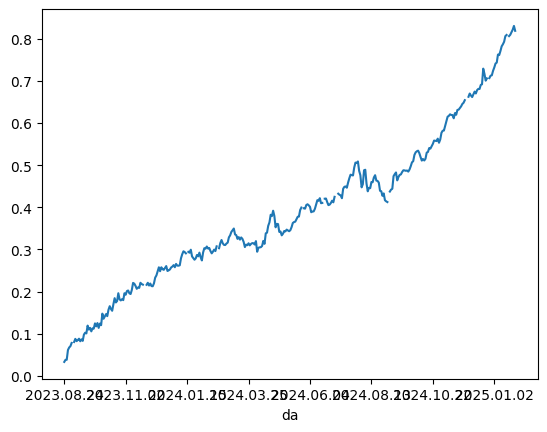

In [178]:
factor = "因子_開盤前5分鐘"
ret = "回報_開盤後到收盤"
grouped_df['signal_dto'] = grouped_df[factor].apply(lambda x: 1 if x < 0 else -1)

grouped_df['profit_dto_5'] = -grouped_df['signal_dto'] * grouped_df[ret]
grouped_df['profit_dto_5'].cumsum().plot()

In [ ]:

stats = calculate_strategy_statistics(grouped_df, 'profit_dto_5')

# Print statistics
for k, v in stats.items():
    print(f"{k}: {v:.2f}")

Sharpe Ratio: 3.86
Sortino Ratio: 5.70
Calmar Ratio: 3.08
Max Drawdown (%): -0.19
Annualized Return (%): 58.28
Win Rate (%): 59.08
Profit Factor: 1.97
